### Mounting the Drive

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


### About Dataset
Context
Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks. The dataset consists of 297

Content
This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In [3]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [4]:
num_classes = len(id_map.keys())
num_classes

31

In [55]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))

    # Normalize the pixel values to the range [0, 1]
    img1 = np.array(img1) / 255.

    # Convert image2 to a NumPy array
    img2 = np.array(img2)

    # Create an empty mask with the same height and width as img2
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)

    # Iterate over each pixel in img2 and find the closest class label using id_map
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key

    # Reshape the mask to have a third dimension (channels)
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

### Loading the Variables

X_train, Y_train, X_valid, and Y_valid are variables that will be loaded with numpy arrays from the specified .npy files. These arrays likely contain data for a semantic segmentation task, where X_train and X_valid are input images, and Y_train and Y_valid are corresponding ground truth segmentation masks or labels.

np.load() is used to load numpy arrays from the specified file paths. It reads the data saved in the .npy files and creates numpy arrays in memory with the loaded data.

In [25]:
# Load variables.
X_train = np.load("/content/drive/MyDrive/Car Semantic Segmentation/npy_files/X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Car Semantic Segmentation/npy_files/Y_train.npy")
X_valid = np.load("/content/drive/MyDrive/Car Semantic Segmentation/npy_files/X_valid.npy")
Y_valid = np.load("/content/drive/MyDrive/Car Semantic Segmentation/npy_files/Y_valid.npy")

# Print info.
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)

X_train shape: (2975, 128, 128, 3)
Y_train shape: (2975, 128, 128, 1)
X_valid shape: (500, 128, 128, 3)
Y_valid shape: (500, 128, 128, 1)


### Creating the Model ( U-Net )

**Input Layer:**
Inputs is defined as the input layer of the U-Net model. It's set to expect images with dimensions [128, 128, 3], where 128x128 is the height and width, and 3 is the number of color channels (e.g., RGB).


**Downsampling Layers :**
These layers perform the downsampling or "contracting" part of the U-Net architecture.
Conv2D layers perform convolution operations with ReLU activation and batch normalization.
MaxPooling2D layers perform max-pooling to reduce the spatial dimensions.
Dropout layers introduce regularization by randomly setting a fraction of input units to 0 during training.


**Upsampling Layers :**
These layers perform the upsampling or "expansive" part of the U-Net architecture.
UpSampling2D layers upsample the feature maps.
Concatenate layers concatenate the upsampled feature maps with corresponding downsampling feature maps.


**Output Layer:**
The final output layer uses a Conv2D layer with a softmax activation function. The number of filters in this layer should match the number of classes (i.e., num_classes), and it produces a segmentation mask for each class.


**Model Compilation:**
The tf.keras.Model is created with inputs as the input and outputs as the output.
The model is returned, which can then be compiled and trained using data.
In the context of semantic segmentation, this U-Net model architecture helps segment an input image into different classes or regions, providing pixel-level predictions for each class.


In [29]:
def get_unet_model():

    inputs = tf.keras.layers.Input(shape = [128, 128, 3])

    # Downsample - 1
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection

    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)

    # Downsample - 2
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection

    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)

    # Downsample - 3
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection

    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)

    # Downsample - 4
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection

    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)

    # Downsample - 5
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)


    # Upsample - 1
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)

    # Upsample - 2
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)

    # Upsample - 3
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)

    # Upsample - 4
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)

    # Output Layer (softmax activation)
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)

    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [30]:
model = get_unet_model()

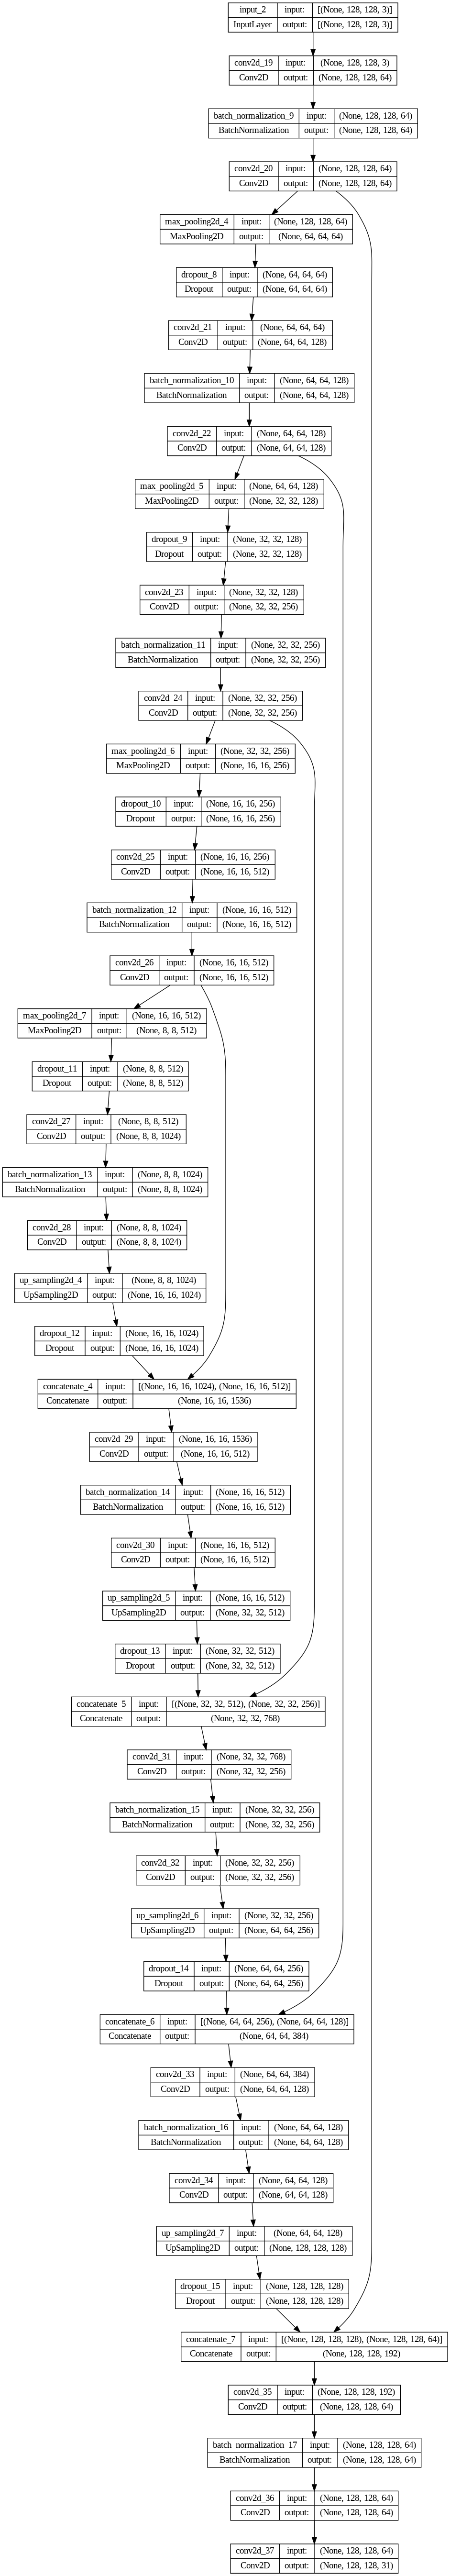

In [31]:
tf.keras.utils.plot_model(model, show_shapes = True)

### Callbacks and Metrics

**UpdatedMeanIoU Class:**
This class is a custom metric class that extends the functionality of tf.keras.metrics.MeanIoU.
It overrides the update_state method to compute mean Intersection over Union (IoU) metric.
y_pred is converted to class predictions using tf.math.argmax.
It is designed to work for multi-class segmentation tasks where each pixel is classified into one of the classes.


**VizCallback Class:**
This class is a custom callback that is used to visualize the predictions of the model during training.
It overrides the on_epoch_end method, which is called at the end of each training epoch.
The method preprocesses an input image and compares the original segmentation mask with the predicted mask.
The original mask and predicted mask are displayed side by side using Matplotlib.
This callback helps monitor the model's progress by visualizing how well it's segmenting images.


**plot_history Function:**
This function is used to plot the training and validation history of a model.
It takes the history object returned by model.fit() as input.
It creates a figure with three subplots to show the comparison of training and validation loss, accuracy, and mean IoU over epochs.
The sns.lineplot function is used to plot these metrics over epochs for both training and validation.
The function helps you visually assess the model's training progress and generalization performance.

In [53]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(x = range(1, len(history.history["loss"]) + 1), y = history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")

  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

The **model.compile()** configures the model for training by specifying the loss function, optimizer, and metrics to track during training. The combination of sparse_categorical_crossentropy as the loss function, **"adam"** as the optimizer, and both accuracy and mean IoU as metrics indicates that the model will be trained to classify pixels into multiple classes while monitoring accuracy and segmentation performance using IoU.

In [48]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

The **EarlyStopping** callback helps control the training process to prevent overfitting, while the **VizCallback** callback provides visual insights into the model's segmentation performance by displaying predicted masks on a specific validation image. Both callbacks contribute to better monitoring and understanding of the training process and model performance.

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("/content/drive/MyDrive/Car Semantic Segmentation/cityscapes_data/cityscapes_data/val/114.jpg")

### Training the Model

The **fit()** function trains the model using the specified training data, labels, and training configuration. The training process will run for the specified number of epochs, and after each epoch, the model's performance on the validation data will be evaluated, and the specified callbacks will be executed. The training history, including loss and metrics values, will be stored in the history object.

Epoch 1/100
1/1 [==============================] - 0s 254ms/step


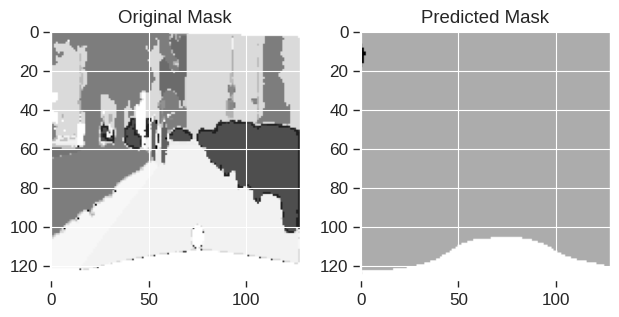

93/93 [==============================] - 68s 624ms/step - loss: 1.1695 - accuracy: 0.6852 - mean_iou: 0.1271 - val_loss: 3.0784 - val_accuracy: 0.3701 - val_mean_iou: 0.0309
Epoch 2/100
1/1 [==============================] - 0s 19ms/step


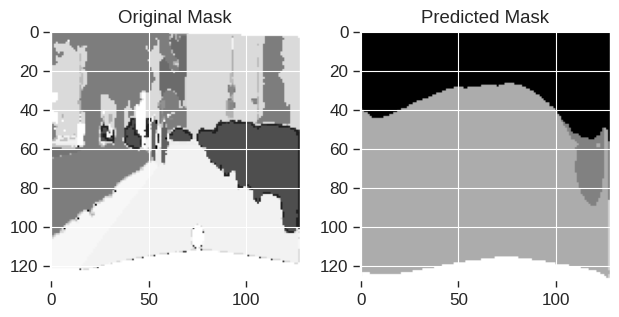

93/93 [==============================] - 60s 650ms/step - loss: 0.8583 - accuracy: 0.7679 - mean_iou: 0.1896 - val_loss: 2.7124 - val_accuracy: 0.5086 - val_mean_iou: 0.0555
Epoch 3/100
1/1 [==============================] - 0s 19ms/step


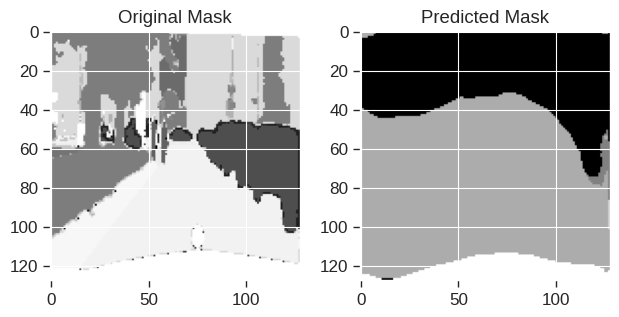

93/93 [==============================] - 58s 625ms/step - loss: 0.7739 - accuracy: 0.7918 - mean_iou: 0.2149 - val_loss: 3.0264 - val_accuracy: 0.5337 - val_mean_iou: 0.0599
Epoch 4/100
1/1 [==============================] - 0s 20ms/step


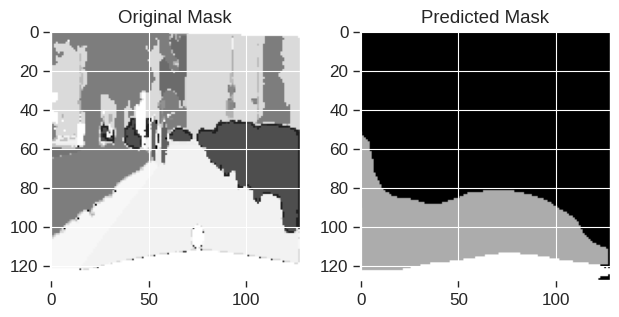

93/93 [==============================] - 58s 627ms/step - loss: 0.7170 - accuracy: 0.8044 - mean_iou: 0.2315 - val_loss: 2.1686 - val_accuracy: 0.4822 - val_mean_iou: 0.0648
Epoch 5/100
1/1 [==============================] - 0s 21ms/step


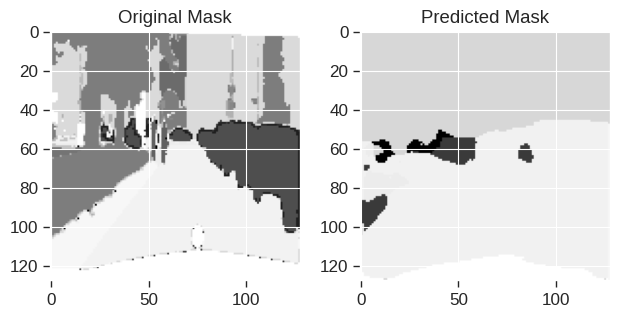

93/93 [==============================] - 80s 861ms/step - loss: 0.6787 - accuracy: 0.8142 - mean_iou: 0.2443 - val_loss: 1.5633 - val_accuracy: 0.6154 - val_mean_iou: 0.1155
Epoch 6/100
1/1 [==============================] - 0s 32ms/step


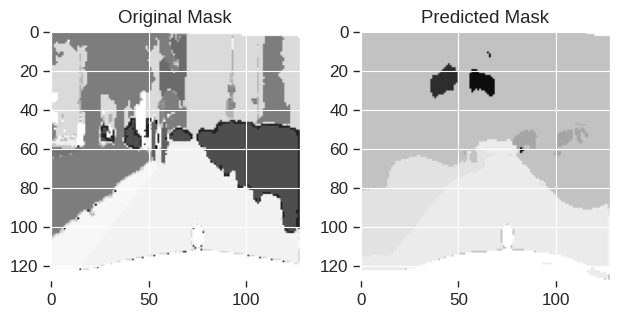

93/93 [==============================] - 58s 624ms/step - loss: 0.6476 - accuracy: 0.8208 - mean_iou: 0.2594 - val_loss: 1.0213 - val_accuracy: 0.7191 - val_mean_iou: 0.1653
Epoch 7/100
1/1 [==============================] - 0s 21ms/step


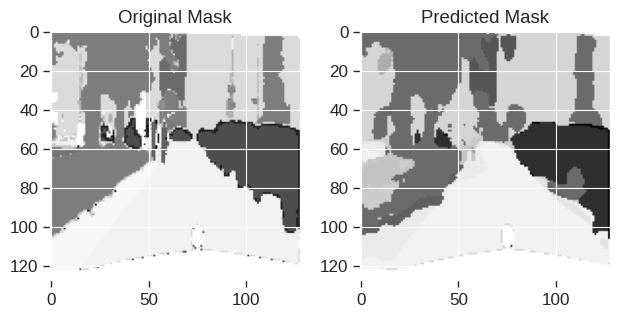

93/93 [==============================] - 60s 641ms/step - loss: 0.6198 - accuracy: 0.8273 - mean_iou: 0.2726 - val_loss: 0.7768 - val_accuracy: 0.7972 - val_mean_iou: 0.2285
Epoch 8/100
1/1 [==============================] - 0s 25ms/step


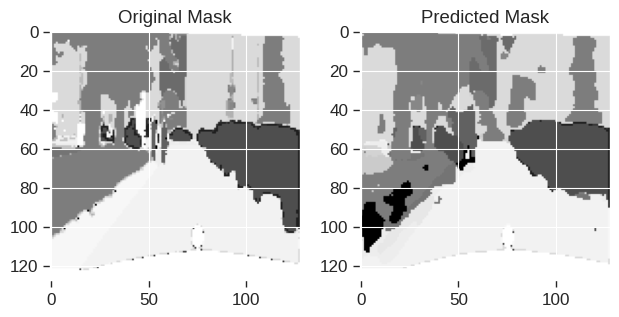

93/93 [==============================] - 58s 623ms/step - loss: 0.5987 - accuracy: 0.8320 - mean_iou: 0.2853 - val_loss: 0.6682 - val_accuracy: 0.8109 - val_mean_iou: 0.2560
Epoch 9/100
1/1 [==============================] - 0s 23ms/step


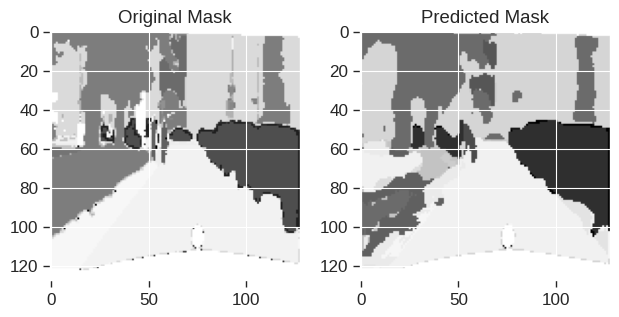

93/93 [==============================] - 58s 627ms/step - loss: 0.5847 - accuracy: 0.8353 - mean_iou: 0.2942 - val_loss: 0.7099 - val_accuracy: 0.8098 - val_mean_iou: 0.2513
Epoch 10/100
1/1 [==============================] - 0s 30ms/step


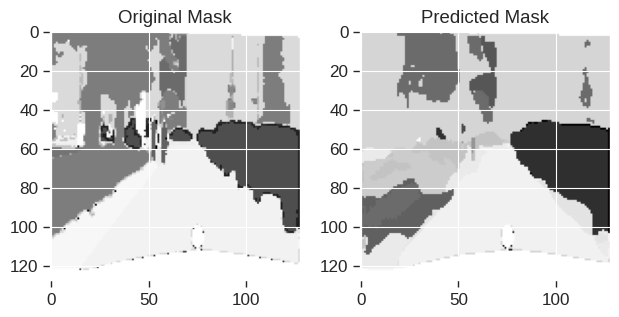

93/93 [==============================] - 60s 644ms/step - loss: 0.5618 - accuracy: 0.8410 - mean_iou: 0.3088 - val_loss: 0.7435 - val_accuracy: 0.7972 - val_mean_iou: 0.2535
Epoch 11/100
1/1 [==============================] - 0s 21ms/step


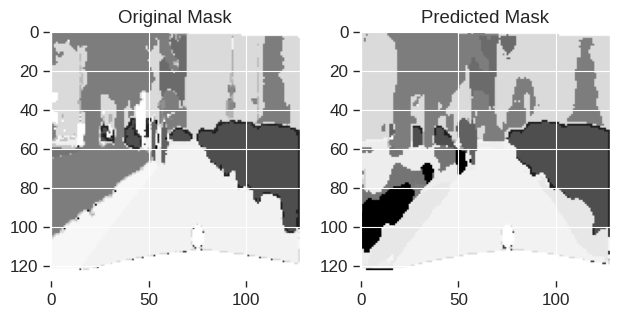

93/93 [==============================] - 59s 635ms/step - loss: 0.5512 - accuracy: 0.8421 - mean_iou: 0.3175 - val_loss: 0.6308 - val_accuracy: 0.8203 - val_mean_iou: 0.2807
Epoch 12/100
1/1 [==============================] - 0s 20ms/step


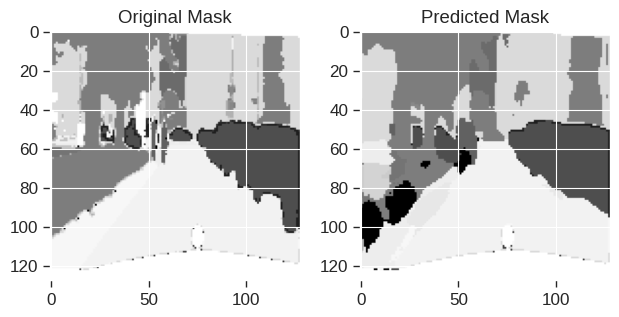

93/93 [==============================] - 58s 629ms/step - loss: 0.5393 - accuracy: 0.8459 - mean_iou: 0.3270 - val_loss: 0.6668 - val_accuracy: 0.8095 - val_mean_iou: 0.2724
Epoch 13/100
1/1 [==============================] - 0s 29ms/step


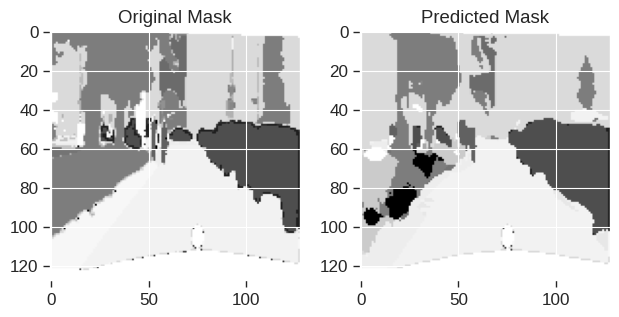

93/93 [==============================] - 59s 631ms/step - loss: 0.5281 - accuracy: 0.8483 - mean_iou: 0.3330 - val_loss: 0.7011 - val_accuracy: 0.8086 - val_mean_iou: 0.2655
Epoch 14/100
1/1 [==============================] - 0s 20ms/step


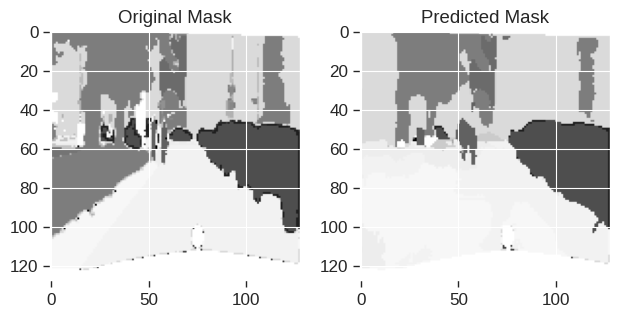

93/93 [==============================] - 59s 636ms/step - loss: 0.5189 - accuracy: 0.8507 - mean_iou: 0.3431 - val_loss: 0.6529 - val_accuracy: 0.8098 - val_mean_iou: 0.2810
Epoch 15/100
1/1 [==============================] - 0s 20ms/step


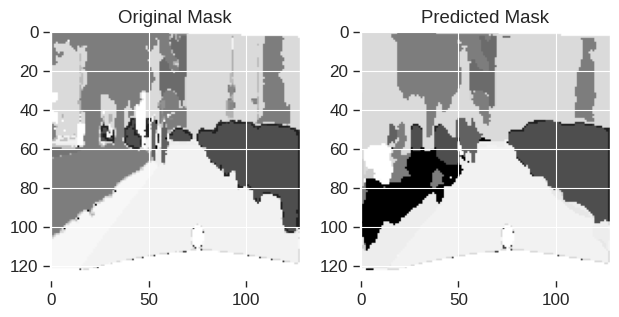

93/93 [==============================] - 58s 626ms/step - loss: 0.4975 - accuracy: 0.8568 - mean_iou: 0.3565 - val_loss: 0.7062 - val_accuracy: 0.8009 - val_mean_iou: 0.2753
Epoch 16/100
1/1 [==============================] - 0s 20ms/step


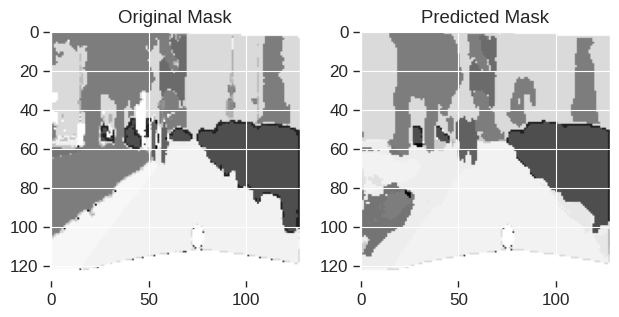

93/93 [==============================] - 58s 624ms/step - loss: 0.4874 - accuracy: 0.8596 - mean_iou: 0.3676 - val_loss: 0.6105 - val_accuracy: 0.8272 - val_mean_iou: 0.3011
Epoch 17/100
1/1 [==============================] - 0s 20ms/step


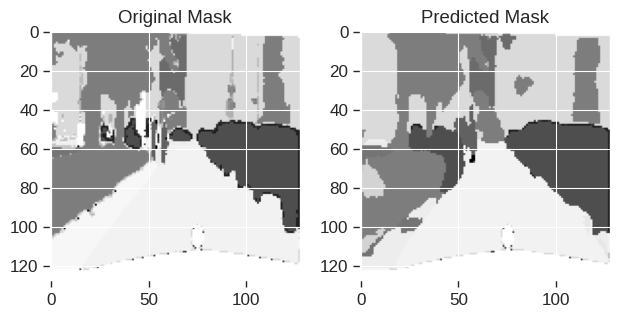

93/93 [==============================] - 60s 646ms/step - loss: 0.4720 - accuracy: 0.8637 - mean_iou: 0.3795 - val_loss: 0.6587 - val_accuracy: 0.8261 - val_mean_iou: 0.2786
Epoch 18/100
1/1 [==============================] - 0s 23ms/step


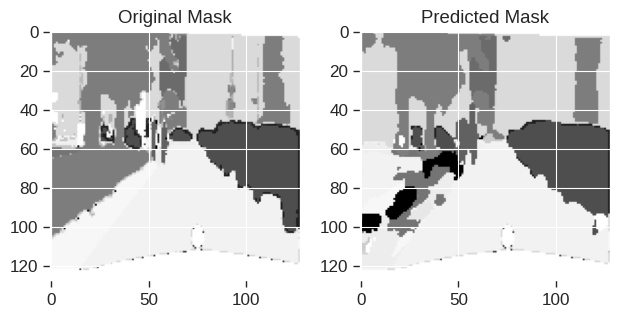

93/93 [==============================] - 58s 624ms/step - loss: 0.4683 - accuracy: 0.8643 - mean_iou: 0.3850 - val_loss: 0.6498 - val_accuracy: 0.8297 - val_mean_iou: 0.2979
Epoch 19/100
1/1 [==============================] - 0s 22ms/step


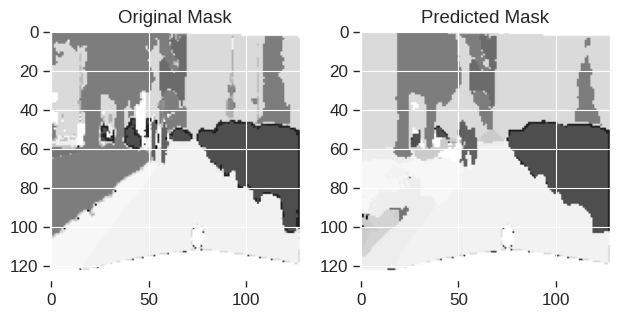

93/93 [==============================] - 58s 627ms/step - loss: 0.4563 - accuracy: 0.8676 - mean_iou: 0.3929 - val_loss: 0.6141 - val_accuracy: 0.8234 - val_mean_iou: 0.3013
Epoch 20/100
1/1 [==============================] - 0s 20ms/step


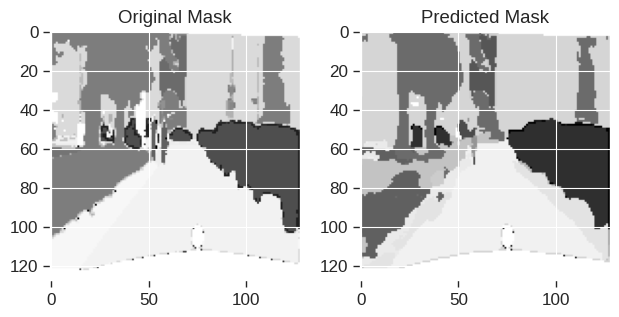

93/93 [==============================] - 59s 640ms/step - loss: 0.4436 - accuracy: 0.8717 - mean_iou: 0.4092 - val_loss: 0.6429 - val_accuracy: 0.8200 - val_mean_iou: 0.2997
Epoch 21/100
1/1 [==============================] - 0s 19ms/step


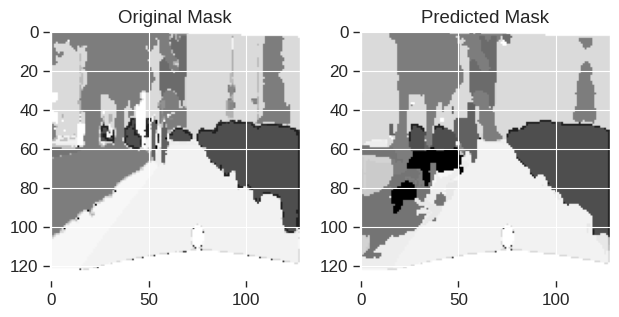

93/93 [==============================] - 58s 629ms/step - loss: 0.4371 - accuracy: 0.8731 - mean_iou: 0.4129 - val_loss: 0.6229 - val_accuracy: 0.8320 - val_mean_iou: 0.3080
Epoch 22/100
1/1 [==============================] - 0s 30ms/step


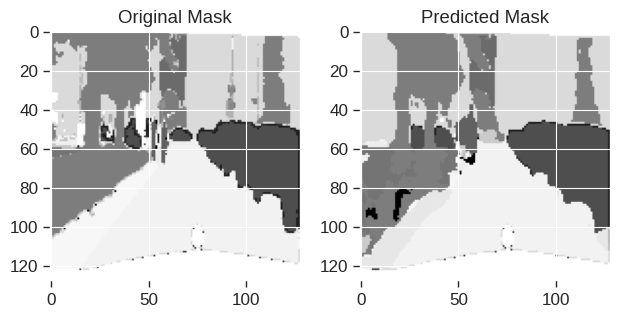

93/93 [==============================] - 59s 631ms/step - loss: 0.4298 - accuracy: 0.8753 - mean_iou: 0.4169 - val_loss: 0.6339 - val_accuracy: 0.8333 - val_mean_iou: 0.3107
Epoch 23/100
1/1 [==============================] - 0s 23ms/step


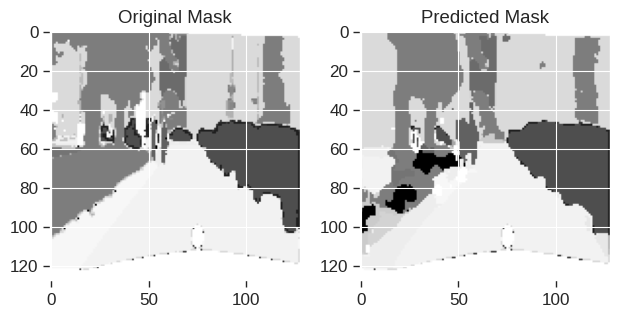

93/93 [==============================] - 60s 641ms/step - loss: 0.4164 - accuracy: 0.8788 - mean_iou: 0.4308 - val_loss: 0.6636 - val_accuracy: 0.8275 - val_mean_iou: 0.3068
Epoch 24/100
1/1 [==============================] - 0s 19ms/step


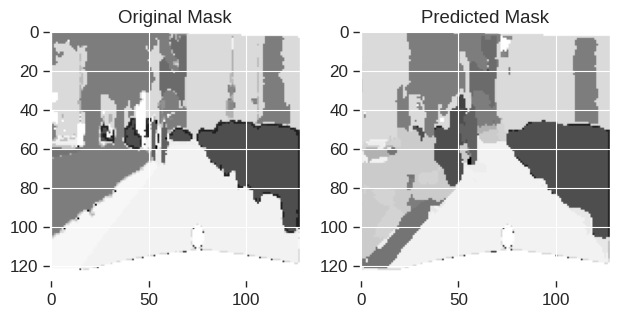

93/93 [==============================] - 58s 628ms/step - loss: 0.4123 - accuracy: 0.8801 - mean_iou: 0.4397 - val_loss: 0.6738 - val_accuracy: 0.8217 - val_mean_iou: 0.3030
Epoch 25/100
1/1 [==============================] - 0s 21ms/step


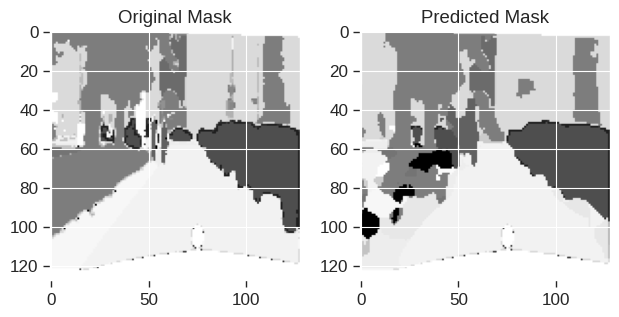

93/93 [==============================] - 58s 624ms/step - loss: 0.4040 - accuracy: 0.8822 - mean_iou: 0.4478 - val_loss: 0.6491 - val_accuracy: 0.8355 - val_mean_iou: 0.3152
Epoch 26/100
1/1 [==============================] - 0s 34ms/step


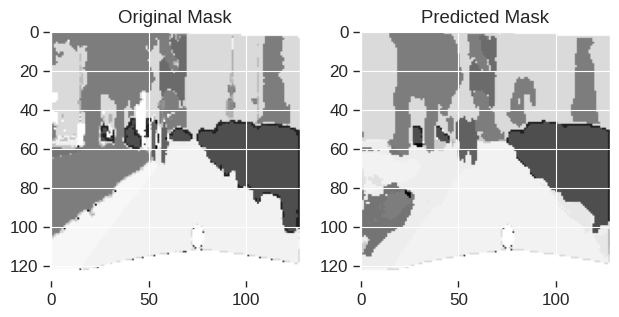

93/93 [==============================] - 58s 630ms/step - loss: 0.3993 - accuracy: 0.8836 - mean_iou: 0.4518 - val_loss: 0.6243 - val_accuracy: 0.8386 - val_mean_iou: 0.3285


In [35]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid), callbacks=[early_stopping, viz_callback])

### Results of the Training process

### Model prediction on VAL set

Plotting the metrics obtained from the **History** object.

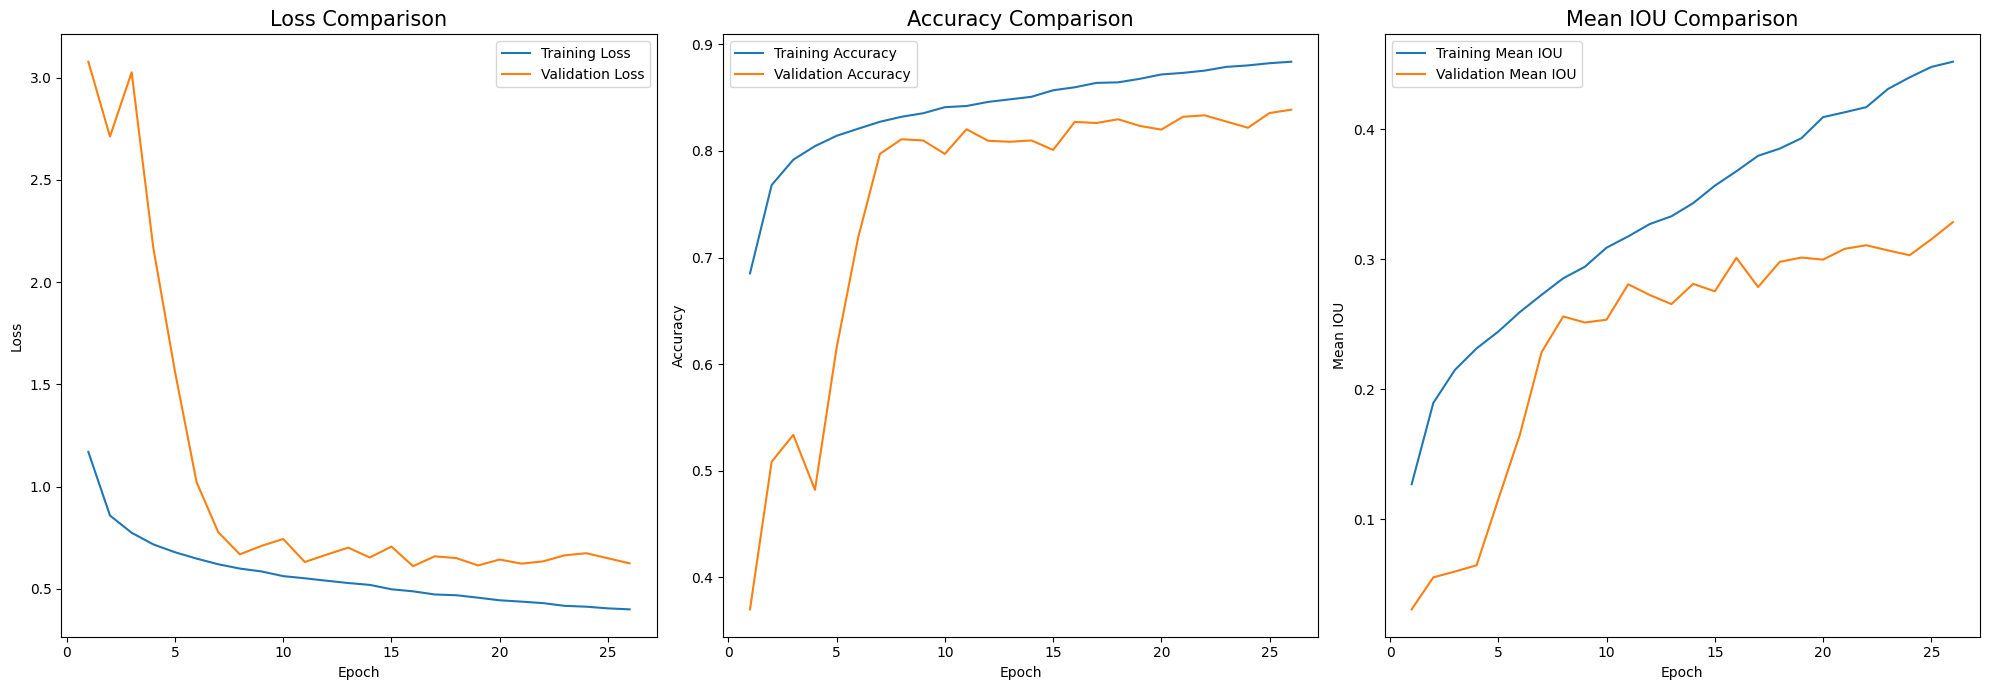

In [54]:
plot_history(history)

1/1 [==============================] - 0s 22ms/step


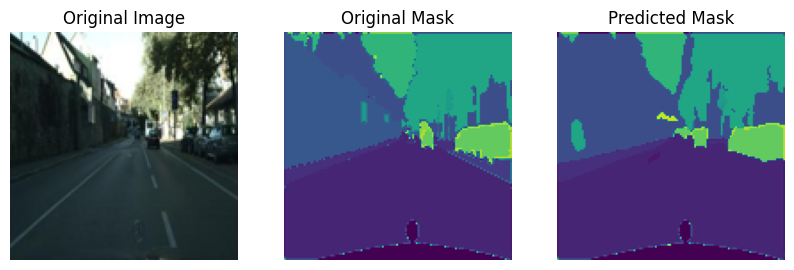

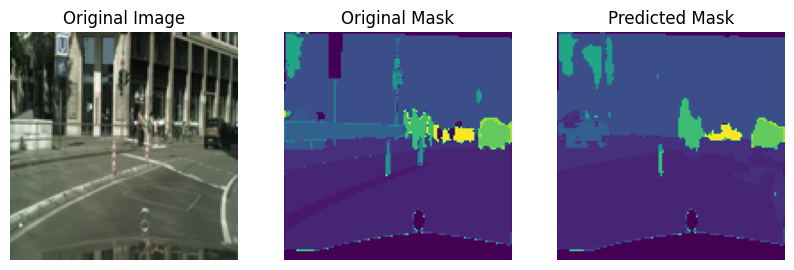

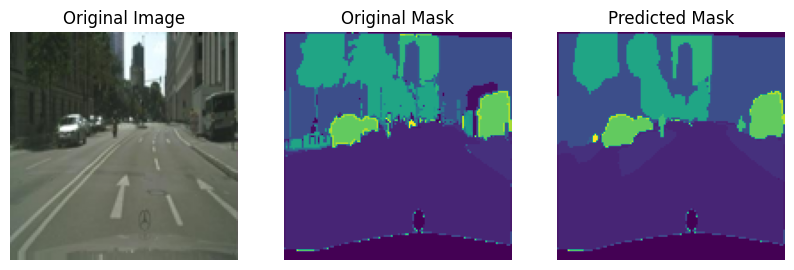

In [38]:
plt.style.use("default")

# This loop iterates through the first three images in the validation directory.
for i in os.listdir("/content/drive/MyDrive/Car Semantic Segmentation/cityscapes_data/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"/content/drive/MyDrive/Car Semantic Segmentation/cityscapes_data/cityscapes_data/val/{i}") # This line reads and preprocesses an image and its corresponding ground truth mask.

    # The next few lines convert the image into the required format for prediction and obtain the model's prediction.
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)

    # The predicted segmentation mask is converted into a visual representation (y_pred).
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))

    # axes[0] displays the original image,
    # axes[1] displays the original mask,
    # axes[2] displays the predicted mask.
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

**Conclusion:**

The provided code demonstrates a complete pipeline for training a semantic segmentation model for car detection using the **U-Net architecture**. It covers data loading, preprocessing, model definition, custom metrics/callbacks, model compilation, training, and visualization of results. The visualizations of predicted masks on sample images help to assess the model's capability to segment cars accurately in real-world scenarios. Through this process, one can learn how to create, train, and evaluate a deep learning model for semantic segmentation tasks using Keras and Google Colab.